In [ ]:
from magnitude.language_model import (
    ARLM, 
    generate_all_sentences,
    random_language
)
from rich import print
import numpy as np

# phrases = random_language(100, 4, alphabet=['A','B','C'], split_token=' ', start = '', end = '')
complete_phrases = [
    "O gato dorme na sala",
    "O gato corre na sala",
    "O cachorro corre no quintal",
]

def generate_incomplete(complete_phrase):
    tokens = complete_phrase.split(" ")
    l_tokens = len(tokens)

    if l_tokens <= 1:
        return ""
    return sorted([" ".join(tokens[:-remove_tokens]) for remove_tokens in range(1,l_tokens)])


incomplete_phrases = np.concat([generate_incomplete(x) for x in complete_phrases]).tolist()

phrases = [*incomplete_phrases, *complete_phrases]
# drop duplicates
phrases = sorted(list(set(phrases)))

model = ARLM(phrases)

print(model.metric_space())

model, history = model.train_model(epochs= 10_000)

print(model.metric_space())



ModuleNotFoundError: No module named 'magnitude'

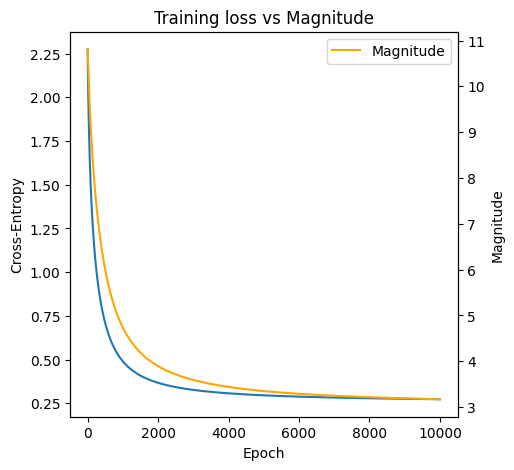

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize = (5,5))

ax.plot(history["Loss"], label = "Loss")

ax.set_xlabel("Epoch")
ax.set_ylabel("Cross-Entropy")

ax_r = ax.twinx()

ax_r.plot(history["Magnitude"], color = "orange", label = "Magnitude")
ax_r.set_ylabel("Magnitude")

plt.legend()
plt.title("Training loss vs Magnitude")
plt.show()

# Translation

In [3]:
import pandas as pd
import numpy as np

ab_phrases = generate_all_sentences(3, alphabet=['A','B'], split_token=' ', start = '', end = '')
cd_phrases = [word.replace('A', 'C').replace('B', 'D') for word in ab_phrases]

models = {
    'AB': ARLM(ab_phrases),
    'CD': ARLM(cd_phrases)
}
epochs = 1_000
magnitudes_history = pd.DataFrame(
    np.zeros((epochs, 2)), 
    columns = list(models.keys())
)

for name, model in models.items():
    print(f'| Training model: {name}')
    initial_mag = model.lm_magnitude()

    model, history = model.train_model(epochs= epochs)
    magnitudes_history[name] = history['Magnitude']

    print(f'Mag(untrained({name})) = {initial_mag:.4f} -----> Mag({name}) = {model.lm_magnitude():.4f}')

| Training model: AB

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:05<00:00, 170.02it/s]


Mag(untrained(AB)) = 9.3996 -----> Mag(AB) = 8.4154

| Training model: CD

100%|██████████| 1000/1000 [00:06<00:00, 159.88it/s]


Mag(untrained(CD)) = 9.7919 -----> Mag(CD) = 8.4160

<Axes: >

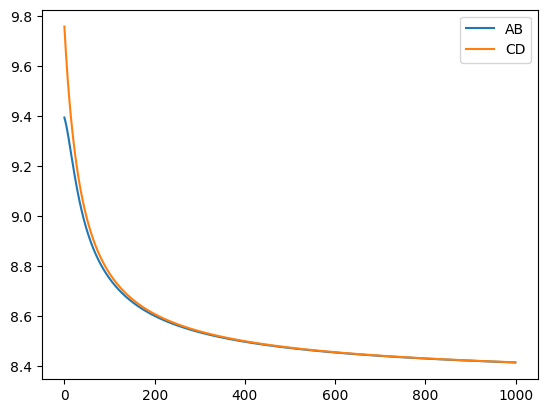

In [4]:
magnitudes_history.plot()

In [23]:
from magnitude.language_model import (
    ARLM, 
    generate_all_sentences,
    random_language
)
from rich import print
import numpy as np


complete_phrases_pt = [
    "O gato dorme na sala",
    "O gato dorme na cozinha",
    "O gato corre na sala",
    "O cachorro corre no quintal",
    "A barata voa na casa"
]
complete_phrases_en = [
    "The cat sleeps in the living room",
    "The cat runs in the living room",
    "The dog runs in the yard",
    "The cockroach flies in the house"
]

def generate_incomplete(complete_phrase):
    tokens = complete_phrase.split(" ")
    l_tokens = len(tokens)

    if l_tokens <= 1:
        return ""
    return sorted([" ".join(tokens[:-remove_tokens]) for remove_tokens in range(1,l_tokens)])

def all_phrases(complete_phrases):
    incomplete_phrases = np.concat([generate_incomplete(x) for x in complete_phrases]).tolist()
    return sorted(list(set([*incomplete_phrases, *complete_phrases])))

phrases_len = {
    "pt": all_phrases(complete_phrases_pt),
    # "en": all_phrases(complete_phrases_en)
}
models = {}
for lang, phrases in phrases_len.items():
    print(f'Language: {lang} ---- Number of phrases: {len(phrases)}')
    model = ARLM(phrases)

    untrained_mag = model.lm_magnitude()

    model, history = model.train_model(epochs= 1_000)

    print(f'Mag = {untrained_mag:.4f} --(training)--> {model.lm_magnitude():.4f}')
    # print(model.metric_space())
    models[lang] = model

Language: pt ---- Number of phrases: 18

100%|██████████| 1000/1000 [00:09<00:00, 105.03it/s]


Mag = 16.9801 --(training)--> 8.7158

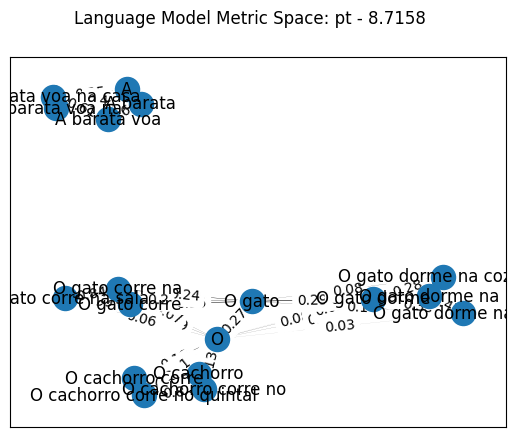

In [24]:
import matplotlib.pyplot as plt

for lang, model in models.items():
    fig = model.metric_space().plot_graph()
    fig.suptitle(f'Language Model Metric Space: {lang} - {model.lm_magnitude():.4f}')
    plt.show()

In [28]:
from rich import print

model = models['pt']
self = model.metric_space()

# [x for x in dir(self) if not x.startswith('_')]

lengths = {sentence: len(sentence.split(' ')) for sentence in self.labels}

dim = 4

def information(self, sentence):
    first_token = sentence.split(' ')[0]

    return self.similarity_pd().loc[first_token, sentence]

chains = {
    sentence: information(self, sentence) for sentence, length in lengths.items() if length == dim+1
}

print(chains)

{
    'A barata voa na casa': np.float64(0.24604065622949178),
    'O cachorro corre no quintal': np.float64(0.10032727577022704),
    'O gato corre na sala': np.float64(0.05586094071744889),
    'O gato dorme na cozinha': np.float64(0.022523880394157977),
    'O gato dorme na sala': np.float64(0.02623123492116815)
}